# Image Classification with PyTorch

## Data loading


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [ ]:
ds_train = datasets.MNIST('data', train=True, download=True)

Each sample is a 28x28 image

(<PIL.Image.Image image mode=L size=28x28 at 0x7FF2D55837C0>, 5)


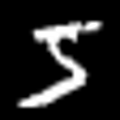

In [ ]:
print(ds_train[0])
ds_train[0][0].resize((120,120))

transform the data to a tensor

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)

In [5]:
type(ds_train[0][0])

torch.Tensor

Normalization

In [6]:
# lets get only the images 
ims_train = ds_train.data
ims_train = ims_train.float() / 255.

In [ ]:

mu = torch.mean(ims_train)
std = torch.std(ims_train)

We normalize the data as below.

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)
ds_test = datasets.MNIST('data', train=False, download=True, transform=transform)

In [9]:
ds_train[0][0].min(), ds_train[0][0].max()

(tensor(-0.4241), tensor(2.8215))

Next, we want to receive mini-batches, not only single data points.
We use PyTorch's DataLoader class


In [ ]:
BATCH_SIZE = 64
NUM_WORKERS = 4
#########################################################################

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, num_workers= NUM_WORKERS, shuffle=False)

## MLP in Pytorch

Let's build our model

In [ ]:

nInput = 784
nOutput = 10
nLayer = 2
nHidden = 16
act_fn = nn.ReLU()

In [ ]:


class MLP(nn.Module):
    def __init__(self, nInput, nOutput, nLayer, nHidden, act_fn):
        super(MLP, self).__init__()
        layers = [] 
        
        layers.append(nn.Linear(nInput,nHidden))
        layers.append(act_fn)
        for i in range(nLayer-2):
            layers.append(nn.Linear(nHidden,nHidden))
            layers.append(act_fn)

        layers.append(nn.Linear(nHidden,nOutput))
        
        ###############################
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.model(x)

In [ ]:
# test if the forward pass works
# should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
mlp(t).shape

torch.Size([1, 10])

In [14]:
mlp

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

test function

In [15]:
def test(model, dl_test, device='cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dl_test.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(dl_test.dataset),
        100. * correct / len(dl_test.dataset)))

Training

In [ ]:


def train(model, dl_train, optimizer, epoch, log_interval=100, device='cpu'):
    model.train()
    correct = 0
    train_loss=0
    for batch_idx, (data, target) in enumerate(dl_train):
        data, target = data.to(device), target.to(device)
        
        # zero the gradient, otherwise PyTorch would accumulate them
        optimizer.zero_grad()         
        
       
        output= model(data)
        loss= F.cross_entropy(output,target)
        loss.backward()
        optimizer.step()
        train_loss+= loss.item()
        ###############################

        # stats
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl_train.dataset),
                100. * batch_idx / len(dl_train), loss.item()))

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        loss, correct, len(dl_train.dataset),
        100. * correct / len(dl_train.dataset)))

We are going to use Adam ad an Optimize

In [ ]:

mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())

In [18]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331825
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.406160
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.385242
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.309892
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.285654
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.187300
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.481597
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.447424
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.533116
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.249155

Train set: Average loss: 0.2093, Accuracy: 53041/60000 (88.4%)


Test set: Average loss: 0.2590, Accuracy: 9240/10000 (92.400%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.195265
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.151395
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.349043
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.240895
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.349235
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.240095
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.323441
Train Epoch: 2 [44800/60000 (75%

some parameter tuning to boost the test accuracy to > **97%**

In [ ]:

nLayer = 5
nHidden = 64
act_fn = nn.ReLU()

# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())

epochs = 40
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308430
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.591933
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.176761
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.538406
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.112436
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.495725
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.095287
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.262857
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.174011
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.167180

Train set: Average loss: 0.1447, Accuracy: 53623/60000 (89.4%)


Test set: Average loss: 0.1734, Accuracy: 9448/10000 (94.480%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.088201
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.057698
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.119408
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.241391
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.129327
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.207890
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.046584
Train Epoch: 2 [44800/60000 (75%

## CNN


| CNN Architecture                             	|
|----------------------------------------------	|
| Conv: $C_{in}=1, C_{out}=32, K=3, S=1, P=0$  	|
| ReLU                                         	|
| Conv: $C_{in}=32, C_{out}=64, K=3, S=1, P=0$ 	|
| ReLU                                         	|
| MaxPool2d: $K=2, S=2, P=0$                   	|
| Dropout: $p=0.25$                            	|
| Linear: $C_{in}=9216, C_{out}=128$           	|
| ReLU                                         	|
| Dropout: $p=0.5$                             	|
| Linear: $C_{in}=128, C_{out}=10$             	|

The layers needed: 

`nn.Conv2d,  nn.Linear,  nn.Dropout, nn.MaxPool2d, nn.Flatten`


In [ ]:


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(p=0.25),
            
            nn.Flatten(),
            
            nn.Linear(in_features=9216, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Linear(in_features=128, out_features=10)
        )

    def forward(self, x):
        # Forward pass through the defined sequential model
        return self.model(x)


In [ ]:
# test if the forward pass works

t = torch.randn(1,1,28,28)
cnn = CNN()
cnn(t).shape

torch.Size([1, 10])

Alright, let's train

In [22]:
optimizer = optim.Adam(cnn.parameters())

In [23]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293918
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.152264
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.131376
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.122954
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.046988
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.047992
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.141084
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.087032
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.115174
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.079967

Train set: Average loss: 0.1136, Accuracy: 56711/60000 (94.5%)


Test set: Average loss: 0.0513, Accuracy: 9833/10000 (98.330%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.073360
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.117034
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.249993
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.067190
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.126971
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.081015
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.026848
Train Epoch: 2 [44800/60000 (75%

**99%** accuracy !


## Training on CIFAR10

Now we are going to train on CIFAR10. We can reuse most of the code above. 

In [24]:
ds_train = datasets.CIFAR10(root='./data', train=True, download=True)

Files already downloaded and verified


This dataset is not normalized yet, so we need to calculate the normalization constants.

In [25]:
ims_train = torch.tensor(ds_train.data)
ims_train = ims_train.float() / 255.

In [26]:
ims_train.std((0,1,2))

tensor([0.2470, 0.2435, 0.2616])

In [ ]:

mu = torch.mean(ims_train, dim=(0,1,2))
std = torch.std(ims_train, dim=(0,1,2))


In [28]:
torch.mean(ims_train, dim=(0,1,2))

tensor([0.4914, 0.4822, 0.4465])

For CIFAR we want to make use of data augmentation to improve generalization.
https://pytorch.org/docs/stable/torchvision/transforms.html

In [ ]:
BATCH_SIZE = 128
NUM_WORKERS = 4 



transform_train = transforms.Compose([transforms.RandomCrop(size=32, padding=4),transforms.RandomHorizontalFlip(p=0.4),transforms.ToTensor(), transforms.Normalize(mu,std)])
transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mu,std)])

ds_train = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
ds_test = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Setting up the  optimizer, this time we use SGD. 


In [30]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [31]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)    
    scheduler.step()

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead

In [ ]:


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(p=0.25),
            
            nn.Flatten(),
            
            nn.Linear(in_features=12544, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Linear(in_features=128, out_features=10)
        )

    def forward(self, x):
        # Forward pass through the defined sequential model
        return self.model(x)


In [33]:
CNN()(torch.randn(1,3,32,32)).shape

torch.Size([1, 10])

**

In [34]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)    
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303667
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.001911
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.833282
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.923108

Train set: Average loss: 1.8310, Accuracy: 12679/50000 (25.4%)


Test set: Average loss: 1.6947, Accuracy: 3648/10000 (36.480%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.787641
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.746006
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.887616
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.759611

Train set: Average loss: 1.7312, Accuracy: 15391/50000 (30.8%)


Test set: Average loss: 1.5848, Accuracy: 4067/10000 (40.670%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.717531
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.763910
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.655622
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.747837

Train set: Average loss: 1.5089, Accuracy: 17601/50000 (35.2%)


Test set: Average loss: 1.5107, Accuracy: 4450/10000 (44.500%)

Train Epoch: 4 [0/50000 (

This gives 40 - 50 %. 